### **Importing Required Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score 

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### **Preparing the Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install split-folders 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Split our folders into test and training set for both Normal and Covid-19 images 
# Using 80% train(20% of the train will be used for validation) and 20% test

import splitfolders
base_path = '/content/drive/MyDrive/Covid-19_Dataset'
splitfolders.ratio(base_path, 'Data', seed=1337, ratio=(.64,.16,.2), group_prefix=None, move=False)

Copying files: 200 files [00:06, 30.43 files/s]


In [6]:
# Define path location of each folder 
main_dir = '/content/Data'

train_path = os.path.join(main_dir,'train')
val_path = os.path.join(main_dir,'val')
test_path = os.path.join(main_dir,'test')

train_covid_path = os.path.join(train_path,'Covid-19')
train_normal_path = os.path.join(train_path,'Normal')

val_covid_path = os.path.join(val_path,'Covid-19')
val_normal_path = os.path.join(val_path,'Normal')

test_covid_path = os.path.join(test_path,'Covid-19')
test_normal_path = os.path.join(test_path,'Normal')

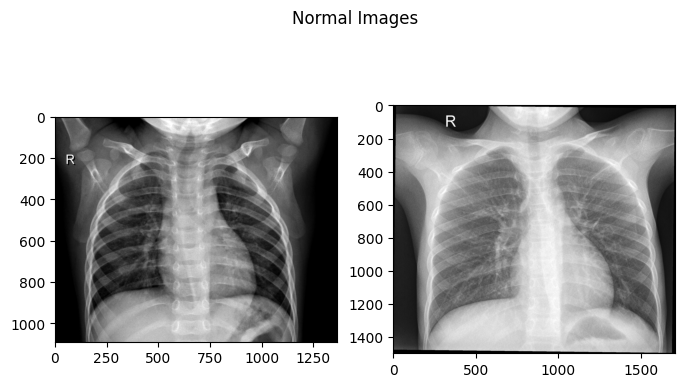

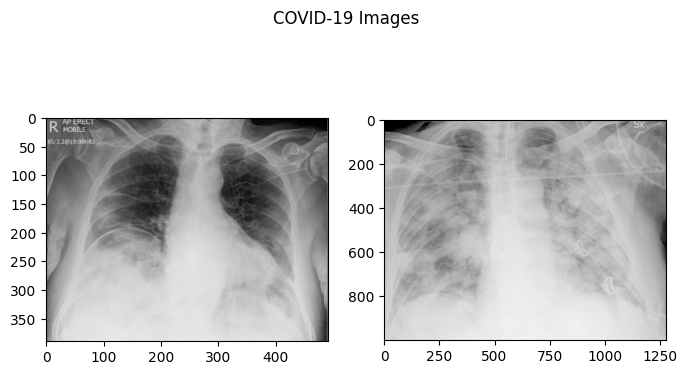

In [7]:
# Visualize some of the images in the dataset to see what they look like. 
# Define function to display images
def display_images(image_list, title):
    plt.figure(figsize=(8, 8))
    plt.suptitle(title, fontsize=12)
    for i in range(len(image_list)):
        plt.subplot(2, 2, i+1)
        plt.imshow(image_list[i], cmap='gray')
    plt.show()

# Load and display two random normal images from the test set
normal_images = os.listdir(test_normal_path)
normal_samples = random.sample(normal_images, 2)
normal_image_list = [Image.open(os.path.join(test_normal_path, img)) for img in normal_samples]
display_images(normal_image_list, "Normal Images")

# Load and display two random covid images from the test set
covid_images = os.listdir(test_covid_path)
covid_samples = random.sample(covid_images, 2)
covid_image_list = [Image.open(os.path.join(test_covid_path, img)) for img in covid_samples]
display_images(covid_image_list, "COVID-19 Images")

As seen above, images have different sizes. They should be resized and normalized to a uniform size before feeding it into our CNN model. 

### **Data Augmentation and Normalization**

In [8]:
# Generating training data using the ImageDataGenerator library 
train_datagen = ImageDataGenerator(
    rescale = 1./255, # Scales the pixel values of the image to the range of 0 to 1. 
    rotation_range=30, # Randomly rotate images up to 30 degrees
    shear_range = 0.2, # Randomly shear images by a maximum of 20% of their width or height.
    #width_shift_range=0.2, # Randomly shift images horizontally by up to 20% of the image width in either direction.
    #height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the image width in either direction.
    zoom_range = 0.2, # Randomly zoom images by a factor of up to 20%
    horizontal_flip = True, # Randomly flip inputs horizontally.
    fill_mode='nearest', # Points outside the boundaries of the input are filled 
    )

# Generating validation data
validation_datagen = ImageDataGenerator(rescale = 1./255) # Scales the pixel values of the image to the range of 0 to 1. 

# Generating test data
test_datagen = ImageDataGenerator(rescale = 1./255) # Scales the pixel values of the image to the range of 0 to 1. 


# Note: Only rescaling was applied to validation and test data. 

In [9]:
# Apply the augmentations defined
train_generator = train_datagen.flow_from_directory(train_path ,
                                                    target_size = (224,224), # Resize all images to 224,224
                                                    subset = 'training',
                                                    batch_size = 8,
                                                    shuffle=True,
                                                    class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(val_path ,
                                                    target_size = (224,224),  # Resize all images to 224,224
                                                    batch_size = 8,
                                                    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_path ,
                                                    target_size = (224,224),  # Resize all images to 224,224
                                                    batch_size = 8,
                                                    class_mode = 'binary')

Found 128 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:
# Classes of images in the train folder 
train_generator.class_indices

{'Covid-19': 0, 'Normal': 1}

Images in each folder have been classed into Normal: 1 and Covid-19: 0

In [11]:
# Size of images in the train folder 
train_generator.image_shape

(224, 224, 3)

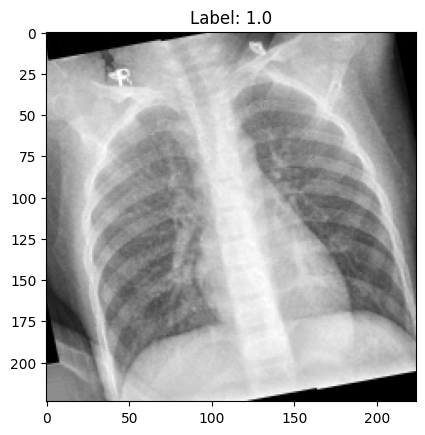

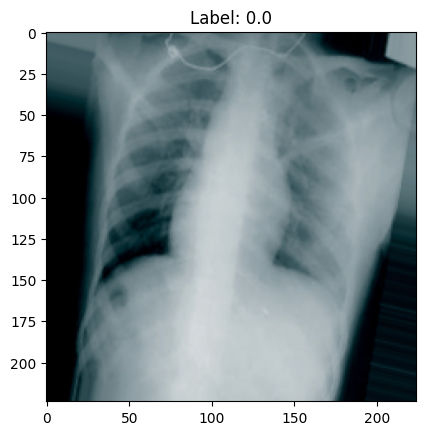

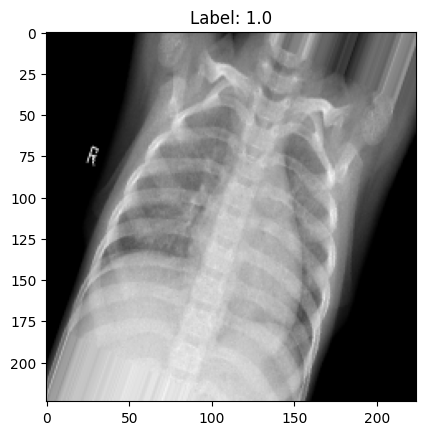

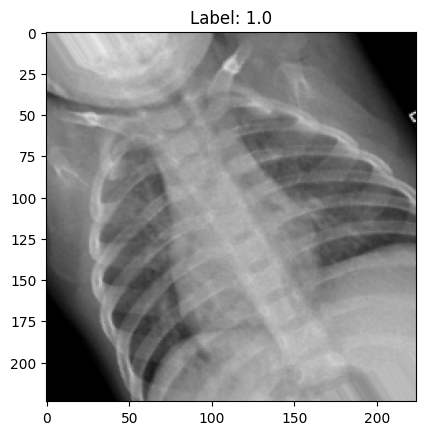

In [12]:
# Get a batch of augmented images from the generator to see what they look like
x_batch, y_batch = train_generator.next()

# Visualize the first 4 images in the batch
for i in range(4):
    image = x_batch[i]
    label = y_batch[i]
    plt.imshow(image)
    plt.title('Label: {}'.format(label))
    plt.show()

**Summary of operations performed**

*   Image folder split in to training, validation and testing. 

* All images reshaped to 224, 224, 3

* Images have been labelled (Covid-19: 0 and Normal: 1)

* Images have been rescaled 

* Images in train folder have been augmented to artificially create more training data from the limited dataset of 100 Normal and 100 Covid-19 CXRs. 


Images are ready to be fed into the Neural Network Models. 

### **Convolutional Neural Network**



In [ ]:
# Build CNN architecture 
model = Sequential()

# Add convolutional layer 
model.add(Conv2D(24,kernel_size= (3,3), padding='same', input_shape=(224,224,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Add pooling layer 
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer 
model.add(Conv2D(48,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Add pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer 
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Add pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the image to 1D array
model.add(Flatten())

# Add a dense layer 
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a dropout layer 
model.add(Dropout(0.4))

# Add a dense layer 
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Prints a summary representation of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 24)      672       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 24)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 48)      10416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 48)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 64)        27712     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 64)      

In [16]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 2, callbacks=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    )

Epoch 1/20
16/16 [==============================] - 17s 330ms/step - loss: 2.6079 - accuracy: 0.5625 - val_loss: 1.8364 - val_accuracy: 0.8125
Epoch 2/20
16/16 [==============================] - 6s 352ms/step - loss: 1.5441 - accuracy: 0.6953 - val_loss: 1.4686 - val_accuracy: 0.6250
Epoch 3/20
16/16 [==============================] - 7s 416ms/step - loss: 1.0285 - accuracy: 0.8203 - val_loss: 0.8317 - val_accuracy: 0.9375
Epoch 4/20
16/16 [==============================] - 7s 414ms/step - loss: 0.8317 - accuracy: 0.8516 - val_loss: 0.6389 - val_accuracy: 1.0000
Epoch 5/20
16/16 [==============================] - 5s 318ms/step - loss: 0.7993 - accuracy: 0.8047 - val_loss: 0.9135 - val_accuracy: 0.8125
Epoch 6/20
16/16 [==============================] - 5s 332ms/step - loss: 0.7075 - accuracy: 0.8672 - val_loss: 0.8276 - val_accuracy: 0.8125
Epoch 7/20
16/16 [==============================] - 5s 313ms/step - loss: 0.6891 - accuracy: 0.8672 - val_loss: 0.4819 - val_accuracy: 0.9375
Epoch

### **Evaluate Performance**

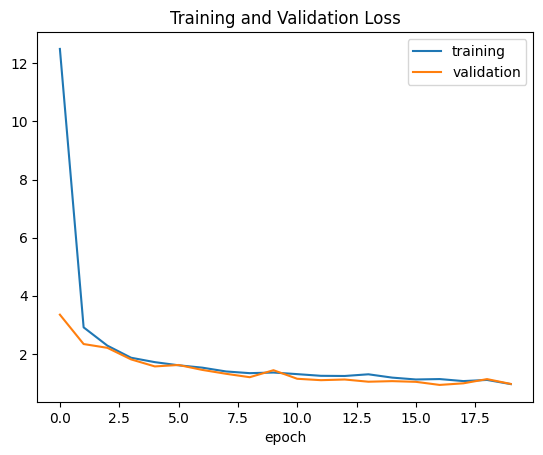

In [31]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('cnn_loss_curve.png')

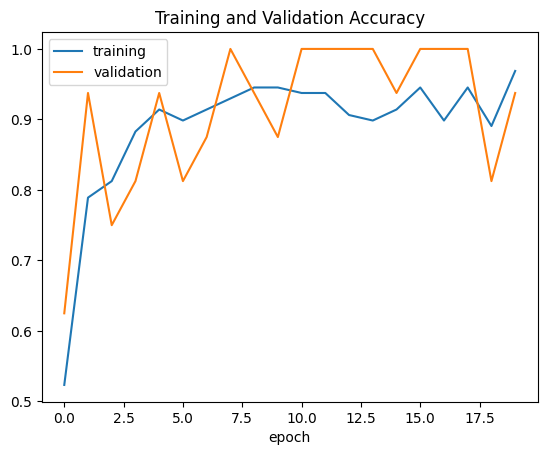

In [32]:
# Plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('cnn_Accuracy_curve.png')

In [ ]:
model.save("CNN.h5")

In [33]:
test_loss , test_acc = model.evaluate(test_generator)
print('Test Accuracy :{} Test Loss:{}'.format(test_acc,test_loss))

5/5 [==============================] - 1s 201ms/step - loss: 0.3807 - accuracy: 0.9750
Test Accuracy :0.9750000238418579 Test Loss:0.3807392120361328


5/5 [==============================] - 1s 191ms/step
Confusion matrix: [[13  7]
 [ 6 14]]
Precision: 0.6666666666666666
F1 score: 0.6829268292682926
Recall: 0.7


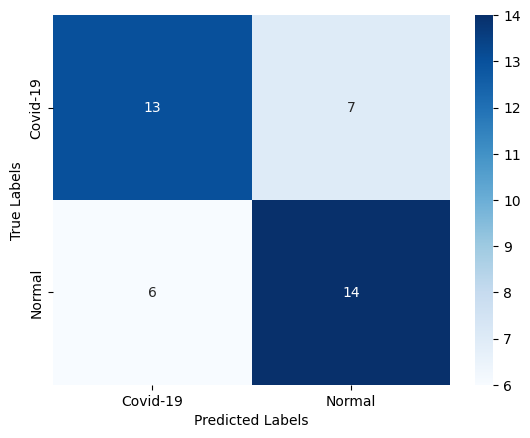

In [ ]:
# Get the actual labels and predicted probabilities from your model
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Get the class names
class_names = test_generator.class_indices.keys()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate Precision Score 
precision = precision_score(y_true, y_pred)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred)

# Calculate the Recall score
recall = recall_score(y_true, y_pred)

# Print the calculated values 
print('Confusion matrix:', cm)
print('Precision:', precision)
print('F1 score:', f1)
print('Recall:', recall)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# Set the axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

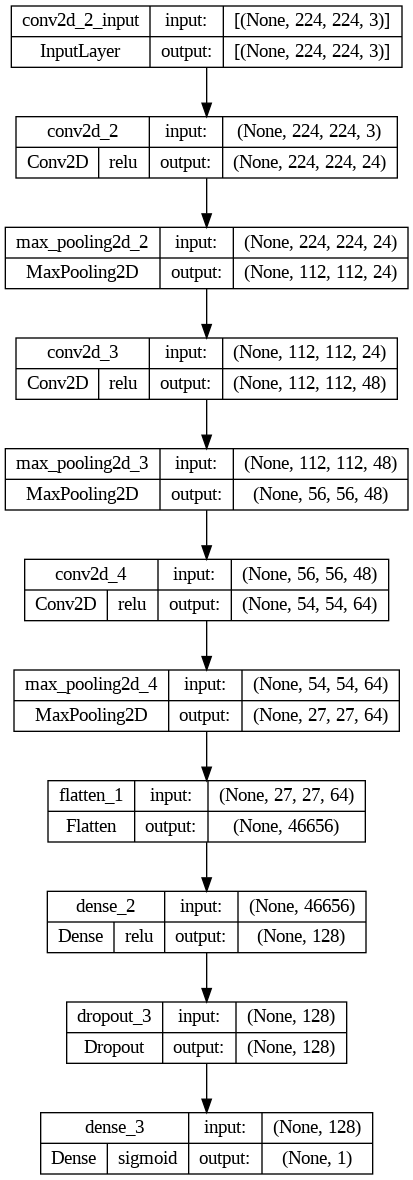

In [ ]:
tf.keras.utils.plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_activations=True, show_layer_names=True)